### Data Splitting

In [ ]:
import os
import random
import shutil
from tqdm import tqdm

# Paths and ratios
base_path = "F:/ACCENT_SPEECH_RECOGNITION/DataBase"
output_base_path = "F:/ACCENT_SPEECH_RECOGNITION/DataBase/Split_Data"
train_ratio, test_ratio, val_ratio = 0.7, 0.2, 0.1

# List of accents
accents = ["bengali", "gujrati", "kannada", "malayalam", "marathi", "rajasthani", "telugu"]

# Create directories for train, test, and validation
for split in ['train', 'test', 'validation']:
    os.makedirs(os.path.join(output_base_path, split), exist_ok=True)

# Collect all files and set up the progress bar for tracking
all_files = []
for accent in accents:
    for gender in ['male', 'female']:
        path = os.path.join(base_path, f"{accent}_{gender}_english/english/wav")
        if os.path.exists(path):
            all_files += [os.path.join(path, f) for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

# Total number of files for the progress bar
with tqdm(total=len(all_files), desc="Splitting Data") as pbar:
    for accent in accents:
        for gender in ['male', 'female']:
            path = os.path.join(base_path, f"{accent}_{gender}_english/english/wav")
            if not os.path.exists(path):
                continue

            files = [os.path.join(path, f) for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
            random.shuffle(files)

            # Split files
            train_files = files[:int(len(files) * train_ratio)]
            test_files = files[int(len(files) * train_ratio):int(len(files) * (train_ratio + test_ratio))]
            val_files = files[int(len(files) * (train_ratio + test_ratio)):]

            # Copy files with error handling
            for split, file_list in zip(['train', 'test', 'validation'], [train_files, test_files, val_files]):
                split_path = os.path.join(output_base_path, split, f"{accent}_{gender}")
                os.makedirs(split_path, exist_ok=True)
                for file in file_list:
                    if os.path.exists(file):
                        shutil.copy(file, split_path)
                    pbar.update(1)

print("Data splitting completed.")

## Feature Extraction and Data Loading

In [6]:
import os
import numpy as np
import joblib
from tqdm import tqdm
import librosa

# Paths to train, test, and validation directories
base_path = 'F:/ACCENT_SPEECH_RECOGNITION/DataBase/Split_Data'
split_dirs = {
    "train": os.path.join(base_path, "train"),
    "test": os.path.join(base_path, "test"),
    "validation": os.path.join(base_path, "validation")
}
output_dir = "F:/ACCENT_SPEECH_RECOGNITION/models"

# Function to extract MFCC features
def extract_mfcc(file_path, n_mfcc=13):
    y, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfcc.T, axis=0)

# Function to load features and labels from a directory
def load_data(directory):
    features, labels = [], []
    for accent_folder in os.listdir(directory):
        accent_label = accent_folder
        folder_path = os.path.join(directory, accent_folder)
        if not os.path.isdir(folder_path):
            continue
        for file in tqdm(os.listdir(folder_path), desc=f"Processing {accent_folder}", leave=False):
            file_path = os.path.join(folder_path, file)
            if os.path.isfile(file_path) and file_path.endswith('.wav'):
                features.append(extract_mfcc(file_path))
                labels.append(accent_label)
    return np.array(features), np.array(labels)

# Load and save data for train, test, and validation sets
for split, dir_path in split_dirs.items():
    X, y = load_data(dir_path)
    joblib.dump((X, y), os.path.join(output_dir, f"{split}_data.pkl"))
    print(f"{split.capitalize()} data saved at {output_dir}/{split}_data.pkl")


Train data saved at F:/ACCENT_SPEECH_RECOGNITION/models/train_data.pkl


Test data saved at F:/ACCENT_SPEECH_RECOGNITION/models/test_data.pkl


Validation data saved at F:/ACCENT_SPEECH_RECOGNITION/models/validation_data.pkl


## Label Encoding

In [1]:
import os
from sklearn.preprocessing import LabelEncoder
import joblib
import numpy as np

output_dir = "F:/ACCENT_SPEECH_RECOGNITION/models"

# Load training labels
_, y_train = joblib.load(os.path.join(output_dir, "train_data.pkl"))

# Encode labels and save encoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
joblib.dump(label_encoder, os.path.join(output_dir, "label_encoder.pkl"))
print("Label encoder saved at", os.path.join(output_dir, "label_encoder.pkl"))


Label encoder saved at F:/ACCENT_SPEECH_RECOGNITION/models\label_encoder.pkl


## Model Training and Cross-Validation

In [4]:
import numpy as np
import joblib
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import tqdm

output_dir = "F:/ACCENT_SPEECH_RECOGNITION/models"

# Load train data and label encoder
X_train, y_train = joblib.load(os.path.join(output_dir, "train_data.pkl"))
label_encoder = joblib.load(os.path.join(output_dir, "label_encoder.pkl"))
y_train_encoded = label_encoder.transform(y_train)

# Initialize models
models = {
    "SVM": SVC(),
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(),
    "Decision Tree": DecisionTreeClassifier()
}

# Cross-validation and results storage
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
results, conf_matrices = {}, {}

for model_name, model in tqdm(models.items(), desc="Evaluating Models"):
    fold_accuracies = []
    all_y_true, all_y_pred = [], []

    for train_index, val_index in skf.split(X_train, y_train_encoded):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train_encoded[train_index], y_train_encoded[val_index]

        model.fit(X_train_fold, y_train_fold)
        y_pred = model.predict(X_val_fold)
        accuracy = accuracy_score(y_val_fold, y_pred)
        fold_accuracies.append(accuracy)

        all_y_true.extend(y_val_fold)
        all_y_pred.extend(y_pred)

    conf_matrices[model_name] = confusion_matrix(all_y_true, all_y_pred)
    results[model_name] = np.mean(fold_accuracies)
    print(f"{model_name} - Mean Accuracy: {results[model_name]:.4f}")

# Save cross-validation results
joblib.dump((results, conf_matrices), os.path.join(output_dir, "cv_results.pkl"))
print("Cross-validation results saved at", os.path.join(output_dir, "cv_results.pkl"))


Evaluating Models:  20%|████████████▊                                                   | 1/5 [05:33<22:13, 333.40s/it]

SVM - Mean Accuracy: 0.9587


C:\Users\abhis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\abhis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Logistic Regression - Mean Accuracy: 0.9787


Evaluating Models:  60%|██████████████████████████████████████▍                         | 3/5 [13:15<08:14, 247.49s/it]

Random Forest - Mean Accuracy: 0.9881


Evaluating Models:  80%|███████████████████████████████████████████████████▏            | 4/5 [14:11<02:51, 171.91s/it]

XGBoost - Mean Accuracy: 0.9895


Evaluating Models: 100%|████████████████████████████████████████████████████████████████| 5/5 [14:26<00:00, 173.27s/it]

Decision Tree - Mean Accuracy: 0.9435
Cross-validation results saved at F:/ACCENT_SPEECH_RECOGNITION/models\cv_results.pkl


## Classification Report

Evaluating Models:   0%|                                                                         | 0/6 [00:00<?, ?it/s]


Classification Report for SVM on Validation Set:
                   precision    recall  f1-score   support

   bengali_female       0.99      0.93      0.96       420
     bengali_male       1.00      1.00      1.00       532
   gujrati_female       0.96      1.00      0.98       467
     gujrati_male       0.92      0.91      0.91       483
   kannada_female       0.90      0.96      0.93       541
     kannada_male       0.97      0.97      0.97       583
 malayalam_female       0.96      0.92      0.94       514
   malayalam_male       0.94      0.94      0.94       514
   marathi_female       0.96      0.98      0.97       506
     marathi_male       0.93      0.94      0.94       558
rajasthani_female       1.00      1.00      1.00       494
  rajasthani_male       1.00      0.97      0.98       595
    telugu_female       0.96      0.97      0.97       297
      telugu_male       0.99      0.99      0.99       319

         accuracy                           0.96      6823
    

Evaluating Models:  17%|██████████▋                                                     | 1/6 [07:26<37:10, 446.09s/it]

                   precision    recall  f1-score   support

   bengali_female       0.98      0.90      0.94       840
     bengali_male       1.00      1.00      1.00      1063
   gujrati_female       0.96      0.99      0.98       934
     gujrati_male       0.92      0.90      0.91       965
   kannada_female       0.90      0.95      0.93      1081
     kannada_male       0.96      0.97      0.97      1165
 malayalam_female       0.95      0.93      0.94      1026
   malayalam_male       0.95      0.93      0.94      1026
   marathi_female       0.97      0.97      0.97      1012
     marathi_male       0.93      0.94      0.94      1116
rajasthani_female       0.99      0.99      0.99       986
  rajasthani_male       1.00      0.98      0.99      1189
    telugu_female       0.94      0.96      0.95       594
      telugu_male       0.98      0.99      0.98       636

         accuracy                           0.96     13633
        macro avg       0.96      0.96      0.96     1

C:\Users\abhis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Evaluating Models:  33%|█████████████████████▎                                          | 2/6 [08:23<14:30, 217.59s/it]


Classification Report for Logistic Regression on Validation Set:
                   precision    recall  f1-score   support

   bengali_female       0.96      0.95      0.95       420
     bengali_male       1.00      1.00      1.00       532
   gujrati_female       1.00      1.00      1.00       467
     gujrati_male       0.95      0.96      0.95       483
   kannada_female       0.96      0.98      0.97       541
     kannada_male       0.99      0.98      0.99       583
 malayalam_female       0.98      0.96      0.97       514
   malayalam_male       0.97      0.97      0.97       514
   marathi_female       0.99      0.99      0.99       506
     marathi_male       0.97      0.97      0.97       558
rajasthani_female       1.00      1.00      1.00       494
  rajasthani_male       1.00      0.99      0.99       595
    telugu_female       0.96      0.97      0.97       297
      telugu_male       1.00      1.00      1.00       319

         accuracy                           0.9

Evaluating Models:  50%|████████████████████████████████                                | 3/6 [08:52<06:33, 131.25s/it]

                   precision    recall  f1-score   support

   bengali_female       1.00      1.00      1.00       840
     bengali_male       1.00      1.00      1.00      1063
   gujrati_female       1.00      0.99      0.99       934
     gujrati_male       0.97      0.96      0.97       965
   kannada_female       0.98      0.99      0.98      1081
     kannada_male       0.99      0.99      0.99      1165
 malayalam_female       0.99      0.99      0.99      1026
   malayalam_male       0.98      0.97      0.98      1026
   marathi_female       0.99      0.99      0.99      1012
     marathi_male       0.98      0.99      0.98      1116
rajasthani_female       1.00      1.00      1.00       986
  rajasthani_male       0.99      0.99      0.99      1189
    telugu_female       1.00      1.00      1.00       594
      telugu_male       0.99      1.00      1.00       636

         accuracy                           0.99     13633
        macro avg       0.99      0.99      0.99     1

Evaluating Models:  67%|███████████████████████████████████████████▎                     | 4/6 [08:59<02:44, 82.40s/it]


Classification Report for XGBoost on Test Set:
                   precision    recall  f1-score   support

   bengali_female       0.99      0.99      0.99       840
     bengali_male       1.00      1.00      1.00      1063
   gujrati_female       1.00      0.99      0.99       934
     gujrati_male       0.98      0.97      0.97       965
   kannada_female       0.99      0.99      0.99      1081
     kannada_male       0.99      0.99      0.99      1165
 malayalam_female       0.99      0.99      0.99      1026
   malayalam_male       0.98      0.98      0.98      1026
   marathi_female       1.00      1.00      1.00      1012
     marathi_male       0.97      0.99      0.98      1116
rajasthani_female       1.00      1.00      1.00       986
  rajasthani_male       1.00      0.99      1.00      1189
    telugu_female       1.00      0.99      0.99       594
      telugu_male       0.99      1.00      0.99       636

         accuracy                           0.99     13633
      

Evaluating Models:  83%|██████████████████████████████████████████████████████▏          | 5/6 [09:01<00:53, 53.46s/it]


Classification Report for Decision Tree on Validation Set:
                   precision    recall  f1-score   support

   bengali_female       0.94      0.94      0.94       420
     bengali_male       0.98      0.98      0.98       532
   gujrati_female       0.94      0.94      0.94       467
     gujrati_male       0.92      0.92      0.92       483
   kannada_female       0.94      0.92      0.93       541
     kannada_male       0.95      0.94      0.94       583
 malayalam_female       0.94      0.95      0.94       514
   malayalam_male       0.93      0.92      0.92       514
   marathi_female       0.96      0.97      0.97       506
     marathi_male       0.93      0.93      0.93       558
rajasthani_female       0.96      0.97      0.97       494
  rajasthani_male       0.97      0.97      0.97       595
    telugu_female       0.98      0.95      0.97       297
      telugu_male       0.95      0.97      0.96       319

         accuracy                           0.95     

Evaluating Models: 100%|█████████████████████████████████████████████████████████████████| 6/6 [11:53<00:00, 93.69s/it]


Classification Report for CNN-LSTM on Test Set:
                   precision    recall  f1-score   support

   bengali_female       1.00      0.99      0.99       840
     bengali_male       1.00      1.00      1.00      1063
   gujrati_female       0.99      0.99      0.99       934
     gujrati_male       0.95      0.97      0.96       965
   kannada_female       0.97      0.99      0.98      1081
     kannada_male       0.99      0.99      0.99      1165
 malayalam_female       0.99      0.97      0.98      1026
   malayalam_male       0.98      0.98      0.98      1026
   marathi_female       0.99      0.99      0.99      1012
     marathi_male       0.97      0.96      0.97      1116
rajasthani_female       1.00      1.00      1.00       986
  rajasthani_male       1.00      0.99      0.99      1189
    telugu_female       0.99      1.00      1.00       594
      telugu_male       1.00      1.00      1.00       636

         accuracy                           0.99     13633
     

Evaluating Models: 100%|████████████████████████████████████████████████████████████████| 6/6 [11:53<00:00, 118.94s/it]


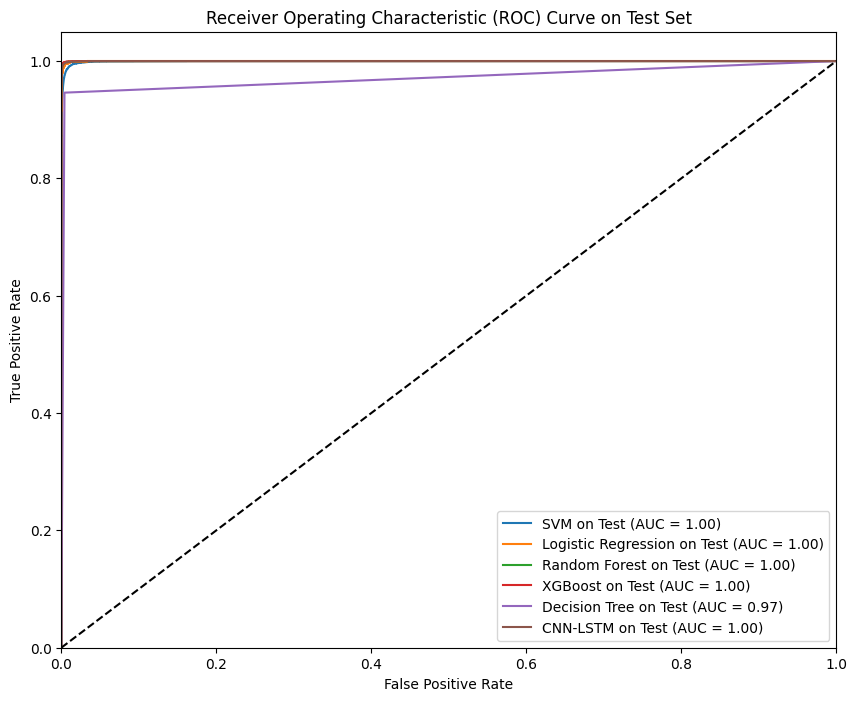


All tuned models saved at F:/ACCENT_SPEECH_RECOGNITION/models\tuned_models.pkl


In [9]:
import os
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm  # for progress bars

# Load datasets and label encoder
output_dir = "F:/ACCENT_SPEECH_RECOGNITION/models"
X_train, y_train = joblib.load(os.path.join(output_dir, "train_data.pkl"))
X_test, y_test = joblib.load(os.path.join(output_dir, "test_data.pkl"))
X_val, y_val = joblib.load(os.path.join(output_dir, "validation_data.pkl"))
label_encoder = joblib.load(os.path.join(output_dir, "label_encoder.pkl"))

# Encode labels for multi-class classification
y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_val_encoded = label_encoder.transform(y_val)

# Reshape data for CNN-LSTM model (assuming single channel)
X_train_cnn_lstm = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn_lstm = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_val_cnn_lstm = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

# Load the CNN-LSTM model from saved file
cnn_lstm_model = load_model(os.path.join(output_dir, "cnn_lstm_accent_model.h5"))
cnn_lstm_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model list
models = {
    "SVM": SVC(probability=True),
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "CNN-LSTM": cnn_lstm_model  # CNN-LSTM model loaded separately
}

# Initialize the plot for ROC curves on the test set
plt.figure(figsize=(10, 8))

# Dictionary to store best models after tuning on validation set
best_models = {}

# Loop through each model with a progress bar
for model_name, model in tqdm(models.items(), desc="Evaluating Models"):
    # Fit the model on the training data
    if model_name == "CNN-LSTM":
        model.fit(X_train_cnn_lstm, y_train_encoded, epochs=10, batch_size=32, validation_data=(X_val_cnn_lstm, y_val_encoded), verbose=0)
        
        # Evaluate on the validation set
        print(f"\nClassification Report for {model_name} on Validation Set:")
        y_val_pred_cnn = model.predict(X_val_cnn_lstm).argmax(axis=1)
        print(classification_report(y_val_encoded, y_val_pred_cnn, target_names=label_encoder.classes_))
        
        # Store the model in the dictionary after validation evaluation
        best_models[model_name] = model
        
        # Predict probabilities for ROC Curve on the test set
        y_test_prob = model.predict(X_test_cnn_lstm)
        y_test_binarized = label_binarize(y_test_encoded, classes=np.arange(len(label_encoder.classes_)))
        
    else:
        model.fit(X_train, y_train_encoded)
        
        # Evaluate on the validation set
        print(f"\nClassification Report for {model_name} on Validation Set:")
        print(classification_report(y_val_encoded, model.predict(X_val), target_names=label_encoder.classes_))
        
        # Store the model in the dictionary after validation evaluation
        best_models[model_name] = model
        
        # Predict probabilities for ROC Curve on the test set
        y_test_prob = model.predict_proba(X_test)
        y_test_binarized = label_binarize(y_test_encoded, classes=np.arange(len(label_encoder.classes_)))
    
    # Compute ROC curve and AUC for each class on the test set
    fpr, tpr, _ = roc_curve(y_test_binarized.ravel(), y_test_prob.ravel())
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve for the test set
    plt.plot(fpr, tpr, label=f"{model_name} on Test (AUC = {roc_auc:.2f})")

    # Final evaluation on the test set
    if model_name == "CNN-LSTM":
        y_test_pred_cnn = model.predict(X_test_cnn_lstm).argmax(axis=1)
        print(f"\nClassification Report for {model_name} on Test Set:")
        print(classification_report(y_test_encoded, y_test_pred_cnn, target_names=label_encoder.classes_))
    else:
        print(f"\nClassification Report for {model_name} on Test Set:")
        print(classification_report(y_test_encoded, model.predict(X_test), target_names=label_encoder.classes_))

# Plot diagonal line for random chance
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve on Test Set')
plt.legend(loc="lower right")
plt.show()

# Optionally, save the tuned models
joblib.dump(best_models, os.path.join(output_dir, "tuned_models.pkl"))
print("\nAll tuned models saved at", os.path.join(output_dir, "tuned_models.pkl"))


## Prediction

In [3]:
import joblib
import tkinter as tk
from tkinter import filedialog
import os
import numpy as np
import librosa

# Define the paths to models and data
model_path = "F:/ACCENT_SPEECH_RECOGNITION/models"
data_path = "F:/ACCENT_SPEECH_RECOGNITION/DataBase/Split_Data/test"

# Load the saved model and label encoder if available
def load_models():
    """Load the best model and label encoder from disk."""
    try:
        best_model = joblib.load(os.path.join(model_path, "best_accent_model.pkl"))
        label_encoder = joblib.load(os.path.join(model_path, "label_encoder.pkl"))
        print("Models loaded successfully.")
        return best_model, label_encoder
    except FileNotFoundError as e:
        print("Error loading model or label encoder:", e)
        return None, None

best_model, label_encoder = load_models()

def select_audio_file():
    """Open a file dialog to select an audio file."""
    root = tk.Tk()
    root.withdraw()  # Hide the main tkinter window
    file_path = filedialog.askopenfilename(
        title="Select an Audio File",
        filetypes=[("WAV files", "*.wav")],
        initialdir=data_path
    )
    return file_path

def extract_mfcc(file_path, n_mfcc=13):
    """Extract and save MFCC features from the audio file."""
    y, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc_mean = np.mean(mfcc.T, axis=0)
    mfcc_file = f"{file_path}.mfcc.npy"  # Save MFCC to avoid re-computation

    # Check if features already exist, load if available
    if os.path.exists(mfcc_file):
        mfcc_mean = np.load(mfcc_file)
    else:
        np.save(mfcc_file, mfcc_mean)  # Save for future use
    return mfcc_mean

def predict_accent(file_path):
    """Predict the accent for a given audio file using the best model."""
    if best_model is None or label_encoder is None:
        print("Model or label encoder not loaded.")
        return None

    mfcc_features = extract_mfcc(file_path).reshape(1, -1)  # Extract and reshape for prediction
    encoded_prediction = best_model.predict(mfcc_features)
    predicted_accent = label_encoder.inverse_transform(encoded_prediction)  # Decode numeric label
    return predicted_accent[0]

# Main prediction workflow
selected_file = select_audio_file()
if selected_file:
    print("Selected File:", os.path.basename(selected_file))
    prediction = predict_accent(selected_file)
    if prediction:
        print("Predicted Accent:", prediction)
    else:
        print("Prediction could not be made.")
else:
    print("No file selected.")


Models loaded successfully.
Selected File: train_malayalammale_00029.wav
Predicted Accent: malayalam_male


## Gender Classification

## Male Data

Label encoder fitted with classes: ['bengali' 'gujrati' 'kannada' 'malayalam' 'marathi' 'rajasthani' 'telugu']


Evaluating Models:   0%|          | 0/5 [00:00<?, ?it/s]


Evaluating SVM on Male Test Set:

Classification Report for SVM on Male Test Set:
              precision    recall  f1-score   support

     bengali       0.99      0.99      0.99      1063
     gujrati       0.86      0.87      0.86       965
     kannada       0.93      0.95      0.94      1165
   malayalam       0.84      0.88      0.86      1026
     marathi       0.90      0.90      0.90      1116
  rajasthani       1.00      0.93      0.96      1189
      telugu       1.00      0.98      0.99       636

    accuracy                           0.93      7160
   macro avg       0.93      0.93      0.93      7160
weighted avg       0.93      0.93      0.93      7160



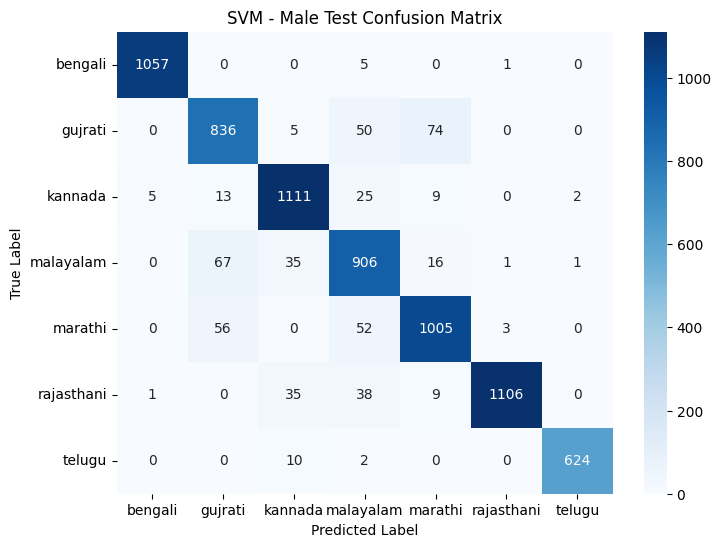


Evaluating Logistic Regression on Male Test Set:


C:\Users\abhis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Classification Report for Logistic Regression on Male Test Set:
              precision    recall  f1-score   support

     bengali       1.00      1.00      1.00      1063
     gujrati       0.96      0.95      0.96       965
     kannada       0.99      0.99      0.99      1165
   malayalam       0.97      0.97      0.97      1026
     marathi       0.98      0.99      0.98      1116
  rajasthani       1.00      1.00      1.00      1189
      telugu       1.00      1.00      1.00       636

    accuracy                           0.99      7160
   macro avg       0.99      0.99      0.99      7160
weighted avg       0.99      0.99      0.99      7160



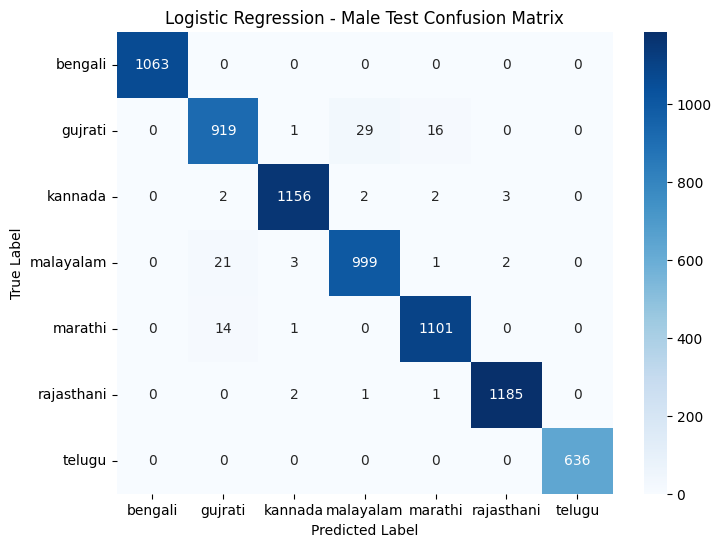


Evaluating Random Forest on Male Test Set:

Classification Report for Random Forest on Male Test Set:
              precision    recall  f1-score   support

     bengali       1.00      1.00      1.00      1063
     gujrati       1.00      1.00      1.00       965
     kannada       1.00      1.00      1.00      1165
   malayalam       1.00      1.00      1.00      1026
     marathi       1.00      1.00      1.00      1116
  rajasthani       1.00      1.00      1.00      1189
      telugu       1.00      1.00      1.00       636

    accuracy                           1.00      7160
   macro avg       1.00      1.00      1.00      7160
weighted avg       1.00      1.00      1.00      7160



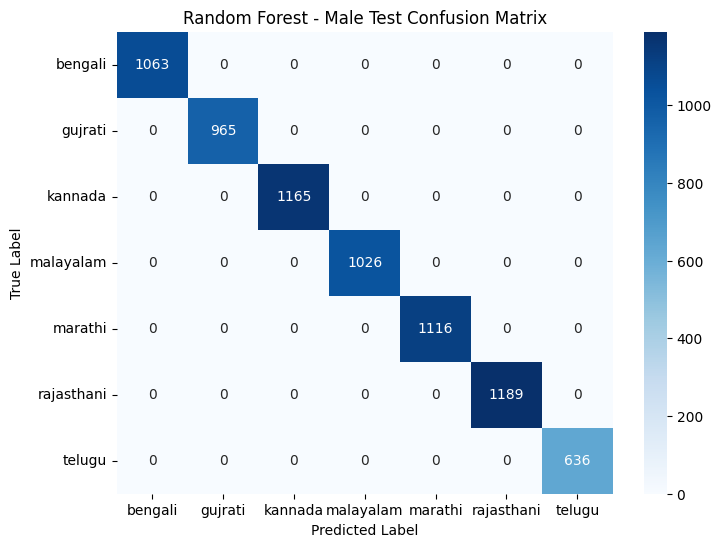


Evaluating XGBoost on Male Test Set:

Classification Report for XGBoost on Male Test Set:
              precision    recall  f1-score   support

     bengali       1.00      1.00      1.00      1063
     gujrati       1.00      1.00      1.00       965
     kannada       1.00      1.00      1.00      1165
   malayalam       1.00      1.00      1.00      1026
     marathi       1.00      1.00      1.00      1116
  rajasthani       1.00      1.00      1.00      1189
      telugu       1.00      1.00      1.00       636

    accuracy                           1.00      7160
   macro avg       1.00      1.00      1.00      7160
weighted avg       1.00      1.00      1.00      7160



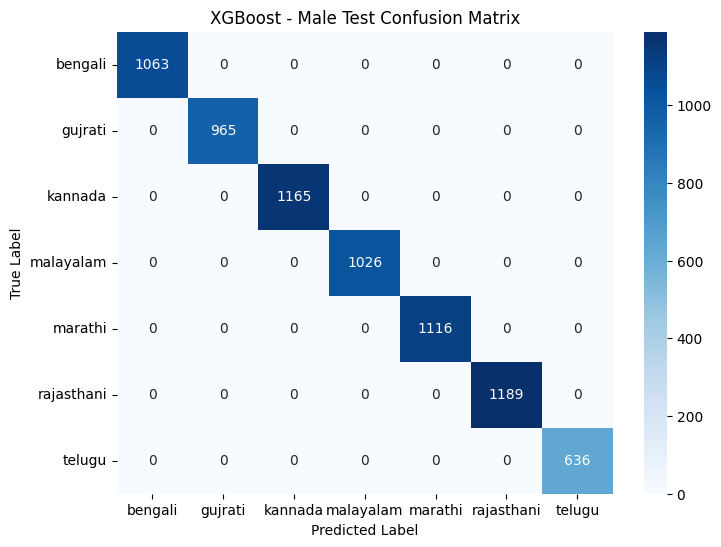


Evaluating Decision Tree on Male Test Set:

Classification Report for Decision Tree on Male Test Set:
              precision    recall  f1-score   support

     bengali       1.00      1.00      1.00      1063
     gujrati       1.00      1.00      1.00       965
     kannada       1.00      1.00      1.00      1165
   malayalam       1.00      1.00      1.00      1026
     marathi       1.00      1.00      1.00      1116
  rajasthani       1.00      1.00      1.00      1189
      telugu       1.00      1.00      1.00       636

    accuracy                           1.00      7160
   macro avg       1.00      1.00      1.00      7160
weighted avg       1.00      1.00      1.00      7160



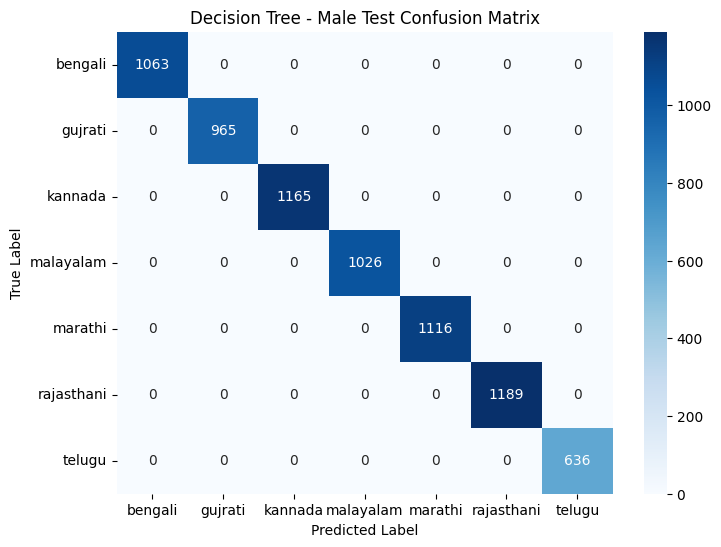

In [1]:
import os
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from tqdm.notebook import tqdm
import librosa

# Paths
output_dir = "F:/ACCENT_SPEECH_RECOGNITION/models"
data_base_path = "F:/ACCENT_SPEECH_RECOGNITION/DataBase/Split_Data"

# Function to collect all labels from the dataset
def collect_all_labels(data_base_path):
    labels = set()
    for subset in ["train", "test", "validation"]:
        for gender in ["male", "female"]:
            directory = os.path.join(data_base_path, subset)
            for accent_folder in os.listdir(directory):
                if accent_folder.endswith(f"_{gender}"):
                    labels.add(accent_folder.split('_')[0])
    return list(labels)

# Fit LabelEncoder on all possible labels
all_labels = collect_all_labels(data_base_path)
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)
joblib.dump(label_encoder, os.path.join(output_dir, "label_encoder.pkl"))
print(f"Label encoder fitted with classes: {label_encoder.classes_}")

# Reload the label encoder
label_encoder = joblib.load(os.path.join(output_dir, "label_encoder.pkl"))

# Function to extract MFCC features
def extract_mfcc(file_path, n_mfcc=13):
    audio, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    mfccs_mean = np.mean(mfccs.T, axis=0)
    return mfccs_mean

# Helper function to load data by gender
def load_data_for_gender(directory, gender):
    features, labels = [], []
    for accent_folder in os.listdir(directory):
        if accent_folder.endswith(f"_{gender}"):
            folder_path = os.path.join(directory, accent_folder)
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                if os.path.isfile(file_path) and file_path.endswith('.wav'):
                    features.append(extract_mfcc(file_path))
                    labels.append(accent_folder.split('_')[0])  # Accent label
    return np.array(features), np.array(labels)

# Load and encode male test data
X_test, y_test = load_data_for_gender(os.path.join(data_base_path, "test"), "male")
y_test_encoded = label_encoder.transform(y_test)

# Model dictionary excluding CNN-LSTM
models = {
    "SVM": SVC(),
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(),
    "Decision Tree": DecisionTreeClassifier()
}

# Evaluation function to compute and plot confusion matrix
def evaluate_and_plot(model, X, y_true, title):
    y_pred = model.predict(X)
    # Ensure compatibility with classification_report
    unique_labels = sorted(list(set(y_true)))
    target_names = [label_encoder.inverse_transform([label])[0] for label in unique_labels]

    print(f"\nClassification Report for {title} on Male Test Set:")
    print(classification_report(y_true, y_pred, labels=unique_labels, target_names=target_names))
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt='g',
                xticklabels=target_names, yticklabels=target_names)
    plt.title(f"{title} - Male Test Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Evaluate all models on the test set
for model_name, model in tqdm(models.items(), desc="Evaluating Models"):
    print(f"\nEvaluating {model_name} on Male Test Set:")
    model.fit(X_test, y_test_encoded)
    evaluate_and_plot(model, X_test, y_test_encoded, model_name)


## Female Data

Label encoder fitted with classes for female data: ['bengali' 'gujrati' 'kannada' 'malayalam' 'marathi' 'rajasthani' 'telugu']


Evaluating Models for Female Data:   0%|          | 0/5 [00:00<?, ?it/s]


Evaluating SVM on Female Test Set:

Classification Report for SVM on Female Test Set:
              precision    recall  f1-score   support

     bengali       0.98      0.92      0.95       840
     gujrati       0.99      1.00      0.99       934
     kannada       0.92      0.95      0.94      1081
   malayalam       0.95      0.93      0.94      1026
     marathi       0.97      0.97      0.97      1012
  rajasthani       0.99      1.00      0.99       986
      telugu       0.93      0.96      0.94       594

    accuracy                           0.96      6473
   macro avg       0.96      0.96      0.96      6473
weighted avg       0.96      0.96      0.96      6473



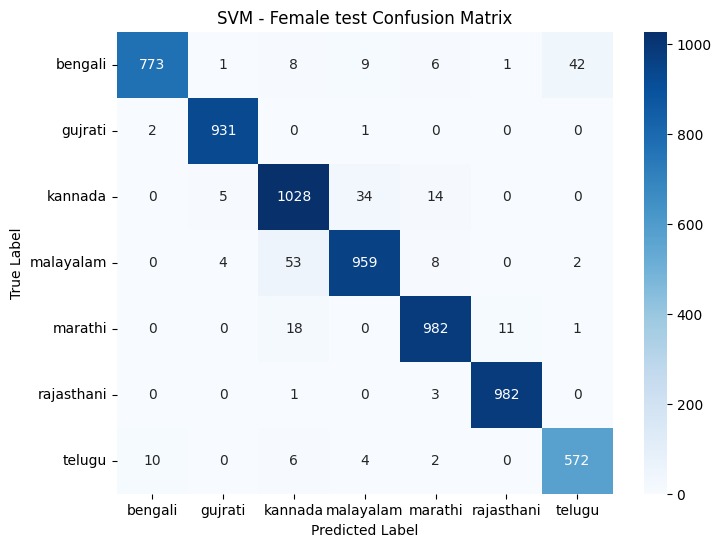


Evaluating Logistic Regression on Female Test Set:


C:\Users\abhis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Classification Report for Logistic Regression on Female Test Set:
              precision    recall  f1-score   support

     bengali       0.98      0.96      0.97       840
     gujrati       1.00      1.00      1.00       934
     kannada       0.98      0.98      0.98      1081
   malayalam       0.98      0.98      0.98      1026
     marathi       0.99      0.99      0.99      1012
  rajasthani       1.00      1.00      1.00       986
      telugu       0.96      0.98      0.97       594

    accuracy                           0.98      6473
   macro avg       0.98      0.98      0.98      6473
weighted avg       0.98      0.98      0.98      6473



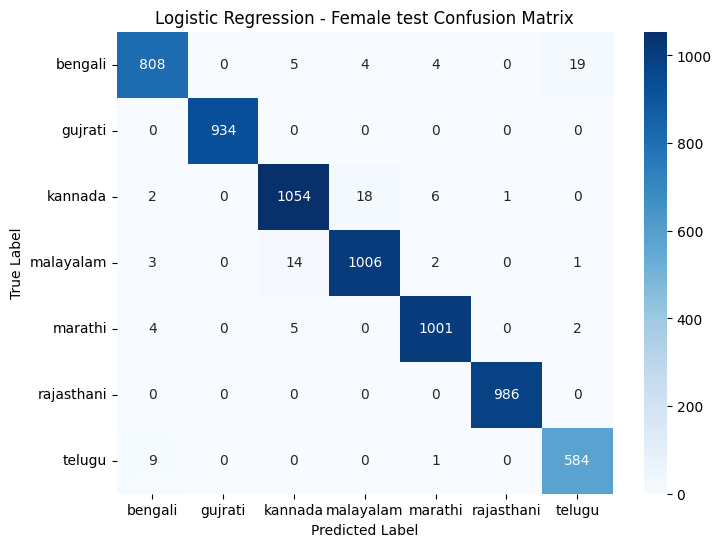


Evaluating Random Forest on Female Test Set:

Classification Report for Random Forest on Female Test Set:
              precision    recall  f1-score   support

     bengali       0.99      1.00      1.00       840
     gujrati       1.00      1.00      1.00       934
     kannada       0.99      0.99      0.99      1081
   malayalam       0.99      0.99      0.99      1026
     marathi       1.00      0.99      0.99      1012
  rajasthani       1.00      1.00      1.00       986
      telugu       0.99      0.99      0.99       594

    accuracy                           0.99      6473
   macro avg       0.99      0.99      0.99      6473
weighted avg       0.99      0.99      0.99      6473



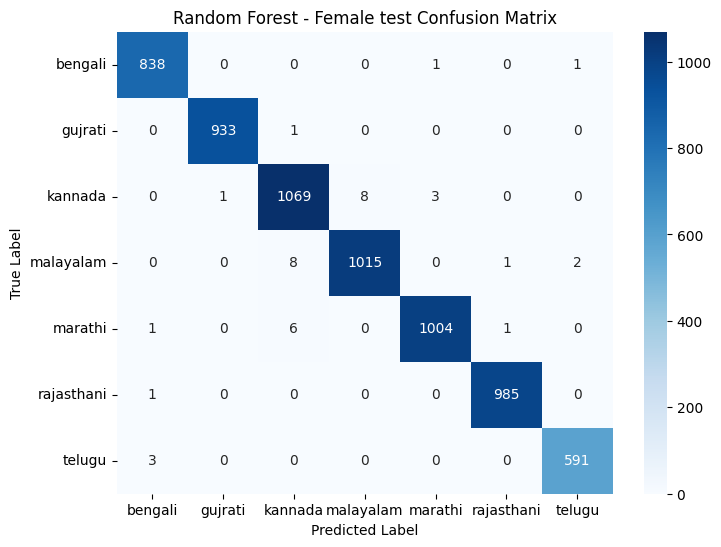


Evaluating XGBoost on Female Test Set:

Classification Report for XGBoost on Female Test Set:
              precision    recall  f1-score   support

     bengali       0.99      1.00      0.99       840
     gujrati       1.00      1.00      1.00       934
     kannada       0.99      0.98      0.99      1081
   malayalam       0.99      0.99      0.99      1026
     marathi       0.99      1.00      1.00      1012
  rajasthani       1.00      1.00      1.00       986
      telugu       1.00      0.99      0.99       594

    accuracy                           0.99      6473
   macro avg       0.99      0.99      0.99      6473
weighted avg       0.99      0.99      0.99      6473



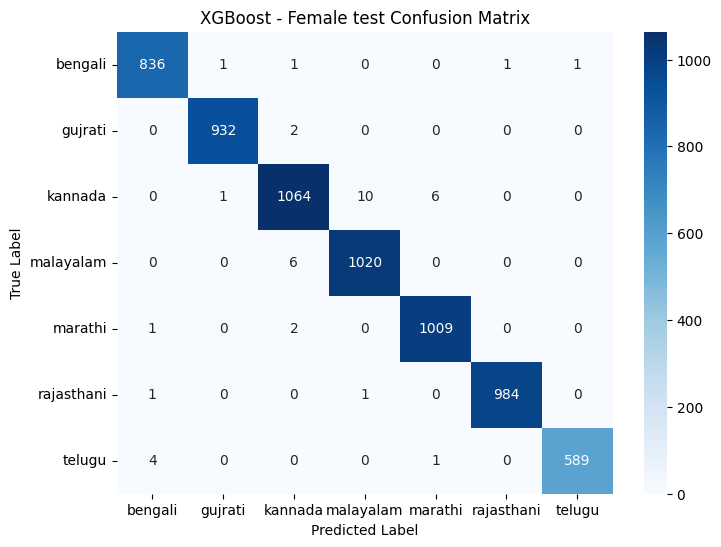


Evaluating Decision Tree on Female Test Set:

Classification Report for Decision Tree on Female Test Set:
              precision    recall  f1-score   support

     bengali       0.98      0.96      0.97       840
     gujrati       0.98      0.99      0.98       934
     kannada       0.95      0.95      0.95      1081
   malayalam       0.96      0.96      0.96      1026
     marathi       0.97      0.97      0.97      1012
  rajasthani       0.99      0.99      0.99       986
      telugu       0.96      0.96      0.96       594

    accuracy                           0.97      6473
   macro avg       0.97      0.97      0.97      6473
weighted avg       0.97      0.97      0.97      6473



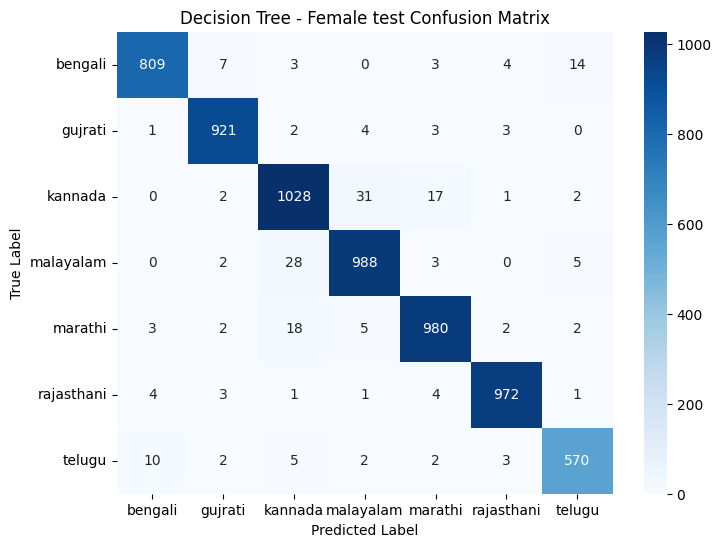

In [7]:
import os
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from tqdm.notebook import tqdm
import librosa

# Paths
output_dir = "F:/ACCENT_SPEECH_RECOGNITION/models"
data_base_path = "F:/ACCENT_SPEECH_RECOGNITION/DataBase/Split_Data"

# Function to collect all labels from the dataset
def collect_all_labels(data_base_path, gender):
    labels = set()
    for subset in ["train", "test", "validation"]:
        directory = os.path.join(data_base_path, subset)
        for accent_folder in os.listdir(directory):
            if accent_folder.endswith(f"_{gender}"):
                labels.add(accent_folder.split('_')[0])
    return list(labels)

# Fit LabelEncoder on all possible labels for female data
all_labels = collect_all_labels(data_base_path, "female")
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)
joblib.dump(label_encoder, os.path.join(output_dir, "label_encoder_female.pkl"))
print(f"Label encoder fitted with classes for female data: {label_encoder.classes_}")

# Reload the label encoder
label_encoder = joblib.load(os.path.join(output_dir, "label_encoder_female.pkl"))

# Function to extract MFCC features
def extract_mfcc(file_path, n_mfcc=13):
    audio, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    mfccs_mean = np.mean(mfccs.T, axis=0)
    return mfccs_mean

# Helper function to load data by gender
def load_data_for_gender(directory, gender):
    features, labels = [], []
    for accent_folder in os.listdir(directory):
        if accent_folder.endswith(f"_{gender}"):
            folder_path = os.path.join(directory, accent_folder)
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                if os.path.isfile(file_path) and file_path.endswith('.wav'):
                    features.append(extract_mfcc(file_path))
                    labels.append(accent_folder.split('_')[0])  # Accent label
    return np.array(features), np.array(labels)

# Load and encode female data
X_train, y_train = load_data_for_gender(os.path.join(data_base_path, "train"), "female")
X_test, y_test = load_data_for_gender(os.path.join(data_base_path, "test"), "female")
X_val, y_val = load_data_for_gender(os.path.join(data_base_path, "validation"), "female")

# Encode labels
y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_val_encoded = label_encoder.transform(y_val)

# Model dictionary
models = {
    "SVM": SVC(probability=True),
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(),
    "Decision Tree": DecisionTreeClassifier()
}

# Evaluation function to compute and plot confusion matrix
def evaluate_and_plot(model, X, y_true, title):
    y_pred = model.predict(X)
    
    print(f"\nClassification Report for {title} on Female Test Set:")
    print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt='g',
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f"{title} - Female test Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Evaluate all models on the female test set
for model_name, model in tqdm(models.items(), desc="Evaluating Models for Female Data"):
    print(f"\nEvaluating {model_name} on Female Test Set:")

    # Fit the model on the training data
    model.fit(X_train, y_train_encoded)

    # Evaluate and plot results on the test set
    evaluate_and_plot(model, X_test, y_test_encoded, model_name)



Evaluating CNN-LSTM Model on Female Test Set:
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

Classification Report for CNN-LSTM Female:
              precision    recall  f1-score   support

     bengali       0.99      0.99      0.99       840
     gujrati       0.00      0.00      0.00       934
     kannada       0.00      0.00      0.00      1081
   malayalam       0.00      0.00      0.00      1026
     marathi       0.00      0.00      0.00      1012
  rajasthani       0.00      0.00      0.00       986
      telugu       0.00      0.00      0.00       594

   micro avg       0.22      0.13      0.16      6473
   macro avg       0.14      0.14      0.14      6473
weighted avg       0.13      0.13      0.13      6473



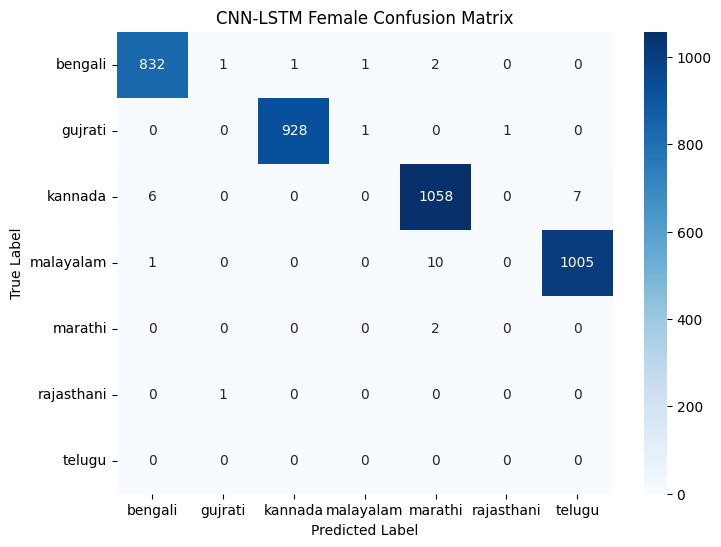


Evaluating CNN-LSTM Model on Male Test Set:
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Classification Report for CNN-LSTM Male:
              precision    recall  f1-score   support

     bengali       0.00      0.00      0.00      1063
     gujrati       0.00      0.00      0.00       965
     kannada       0.50      0.00      0.01      1165
   malayalam       0.01      0.01      0.01      1026
     marathi       0.60      0.00      0.01      1116
  rajasthani       0.00      0.00      0.00      1189
      telugu       0.00      0.00      0.00       636

   micro avg       0.01      0.00      0.00      7160
   macro avg       0.16      0.00      0.00      7160
weighted avg       0.18      0.00      0.00      7160



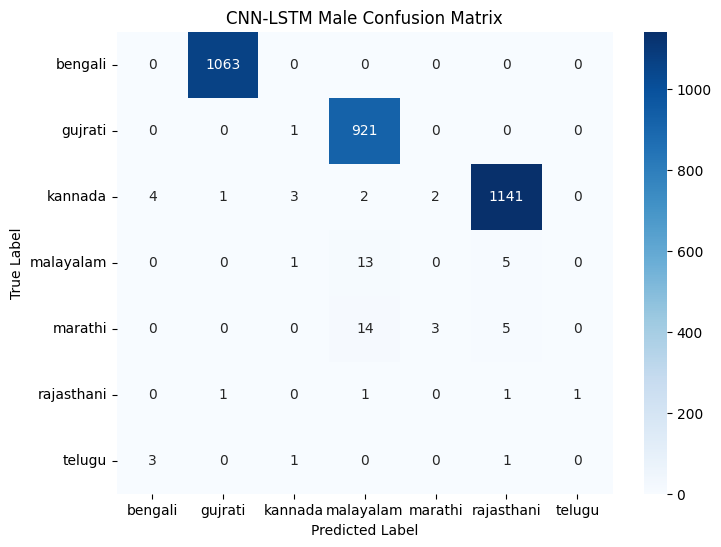

In [2]:
import os
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
import librosa
from tqdm.notebook import tqdm

# Paths
output_dir = "F:/ACCENT_SPEECH_RECOGNITION/models"
data_base_path = "F:/ACCENT_SPEECH_RECOGNITION/DataBase/Split_Data"
cnn_lstm_model_path = os.path.join(output_dir, "cnn_lstm_accent_model.h5")

# Load label encoders
label_encoder_female = joblib.load(os.path.join(output_dir, "label_encoder_female.pkl"))
label_encoder_male = joblib.load(os.path.join(output_dir, "label_encoder_male.pkl"))

# Function to extract MFCC features
def extract_mfcc(file_path, n_mfcc=13):
    audio, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    mfccs_mean = np.mean(mfccs.T, axis=0)
    return mfccs_mean

# Helper function to load data by gender
def load_data_for_gender(directory, gender, label_encoder):
    features, labels = [], []
    for accent_folder in os.listdir(directory):
        if accent_folder.endswith(f"_{gender}"):
            folder_path = os.path.join(directory, accent_folder)
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                if os.path.isfile(file_path) and file_path.endswith('.wav'):
                    features.append(extract_mfcc(file_path))
                    label = accent_folder.split('_')[0]
                    labels.append(label_encoder.transform([label])[0])  # Encode label
    return np.array(features), np.array(labels)

# Load and encode data
X_test_female, y_test_female = load_data_for_gender(os.path.join(data_base_path, "test"), "female", label_encoder_female)
X_test_male, y_test_male = load_data_for_gender(os.path.join(data_base_path, "test"), "male", label_encoder_male)

# Reshape data for CNN-LSTM
X_test_female_cnn_lstm = X_test_female.reshape(X_test_female.shape[0], X_test_female.shape[1], 1)
X_test_male_cnn_lstm = X_test_male.reshape(X_test_male.shape[0], X_test_male.shape[1], 1)

# Load the CNN-LSTM model and compile it
cnn_lstm_model = load_model(cnn_lstm_model_path)
cnn_lstm_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Evaluation function to compute and plot confusion matrix
def evaluate_and_plot(model, X, y_true, title, label_encoder):
    y_pred = model.predict(X).argmax(axis=-1)
    unique_labels = np.unique(y_true)
    target_names = [label_encoder.inverse_transform([label])[0] for label in unique_labels]
    
    print(f"\nClassification Report for {title}:")
    print(classification_report(y_true, y_pred, labels=unique_labels, target_names=target_names))
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred, labels=unique_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt='g',
                xticklabels=target_names, yticklabels=target_names)
    plt.title(f"{title} Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Evaluate CNN-LSTM model on both female and male test sets
print("\nEvaluating CNN-LSTM Model on Female Test Set:")
evaluate_and_plot(cnn_lstm_model, X_test_female_cnn_lstm, y_test_female, "CNN-LSTM Female", label_encoder_female)

print("\nEvaluating CNN-LSTM Model on Male Test Set:")
evaluate_and_plot(cnn_lstm_model, X_test_male_cnn_lstm, y_test_male, "CNN-LSTM Male", label_encoder_male)


## Final Best Model Selection and Test Evaluation

Evaluating Models:   0%|                                                                         | 0/6 [00:00<?, ?it/s]


Evaluating SVM:

Training Set Results:


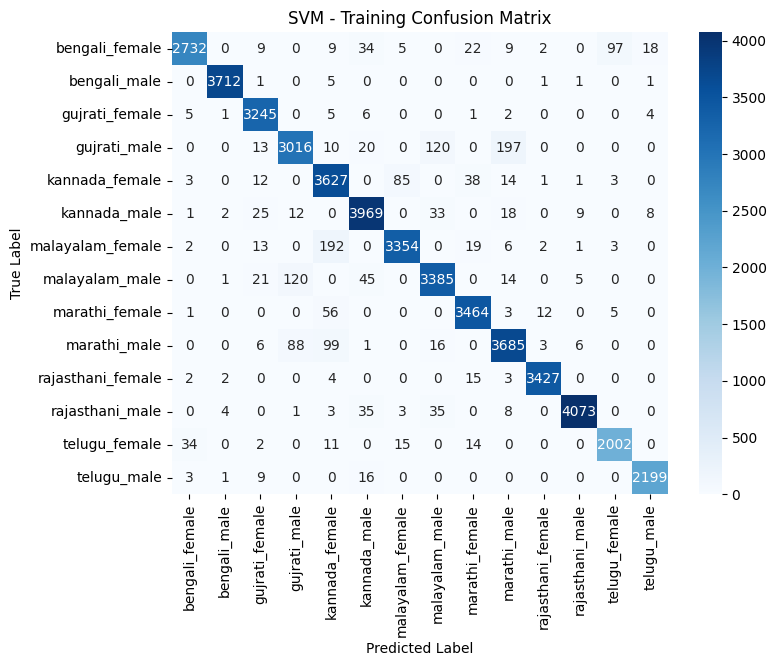

SVM Training Accuracy: 96.18%

Validation Set Results:


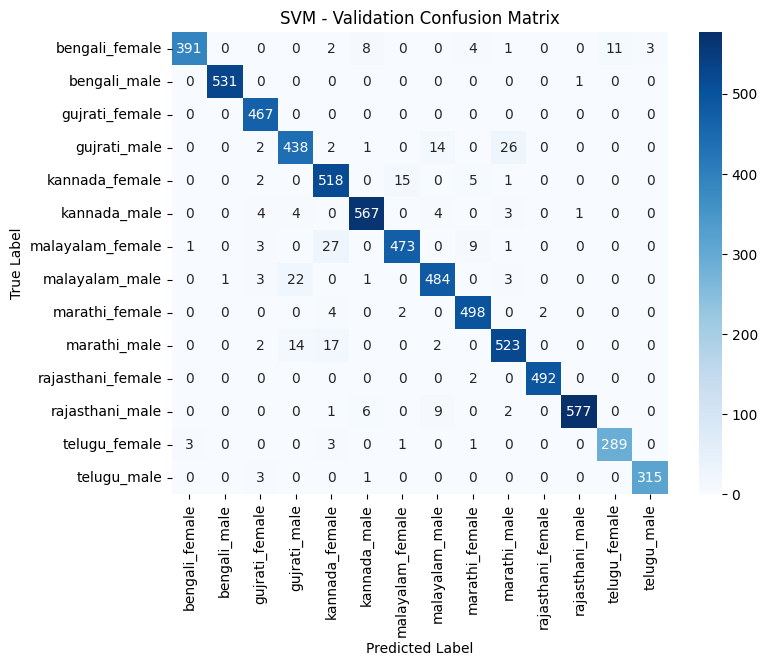

SVM Validation Accuracy: 96.19%

Test Set Results:


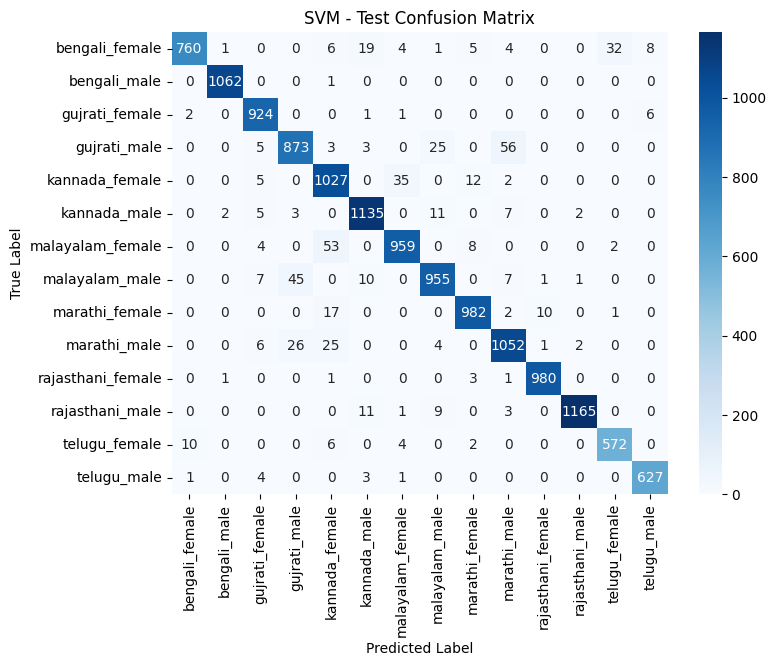

Evaluating Models:  17%|██████████▋                                                     | 1/6 [06:55<34:39, 415.92s/it]

SVM Test Accuracy: 95.89%

Evaluating Logistic Regression:


C:\Users\abhis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Training Set Results:


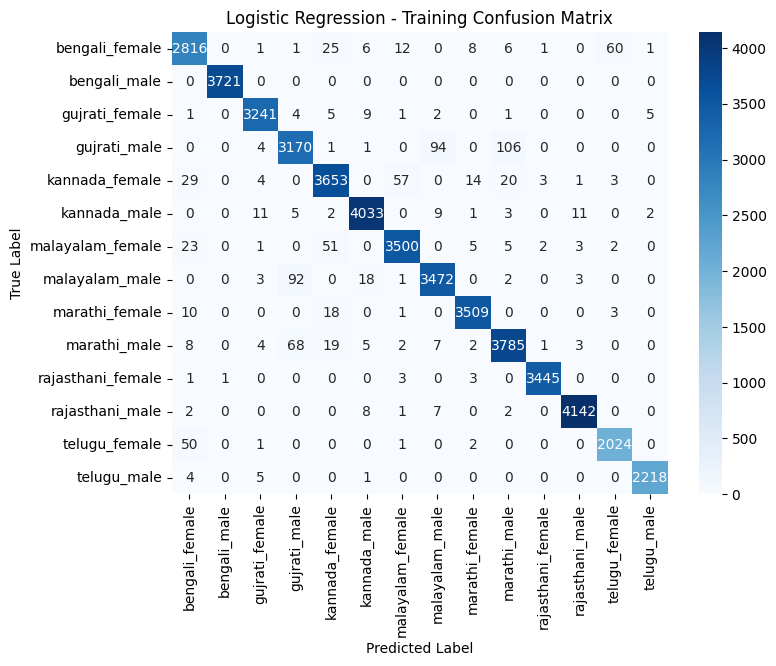

Logistic Regression Training Accuracy: 97.94%

Validation Set Results:


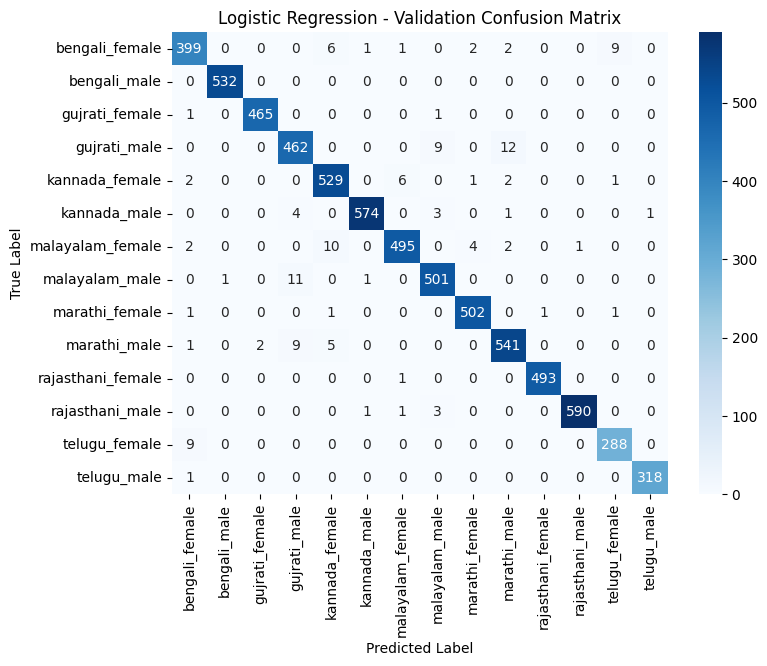

Logistic Regression Validation Accuracy: 98.04%

Test Set Results:


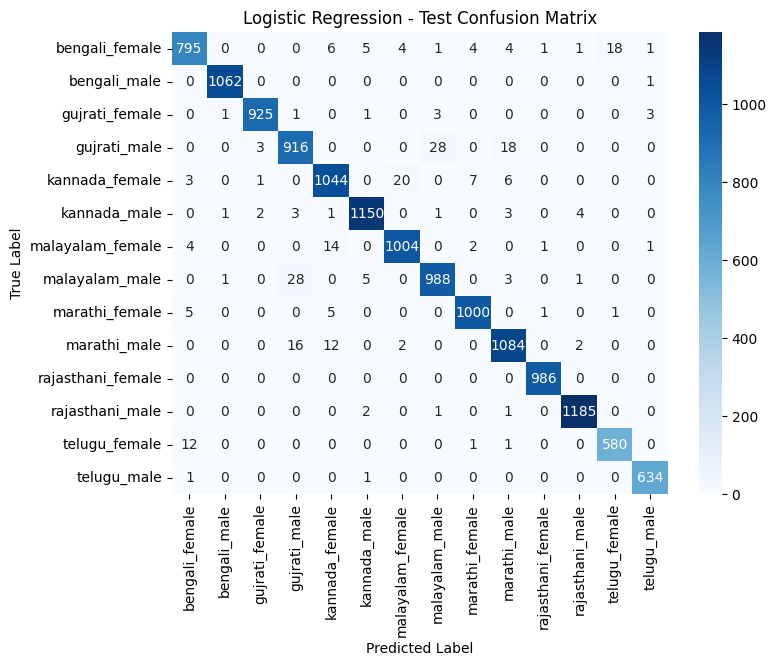

Evaluating Models:  33%|█████████████████████▎                                          | 2/6 [07:57<13:48, 207.20s/it]

Logistic Regression Test Accuracy: 97.95%

Evaluating Random Forest:

Training Set Results:


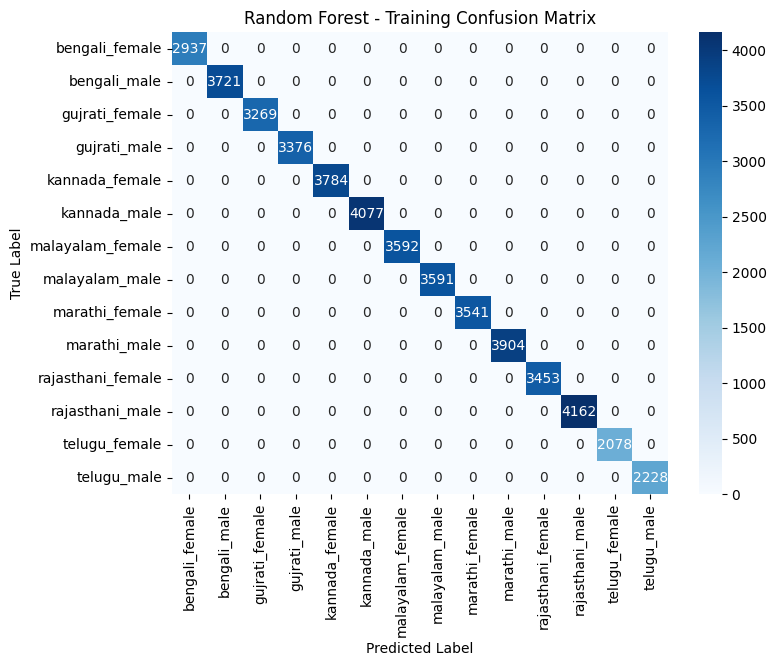

Random Forest Training Accuracy: 100.00%

Validation Set Results:


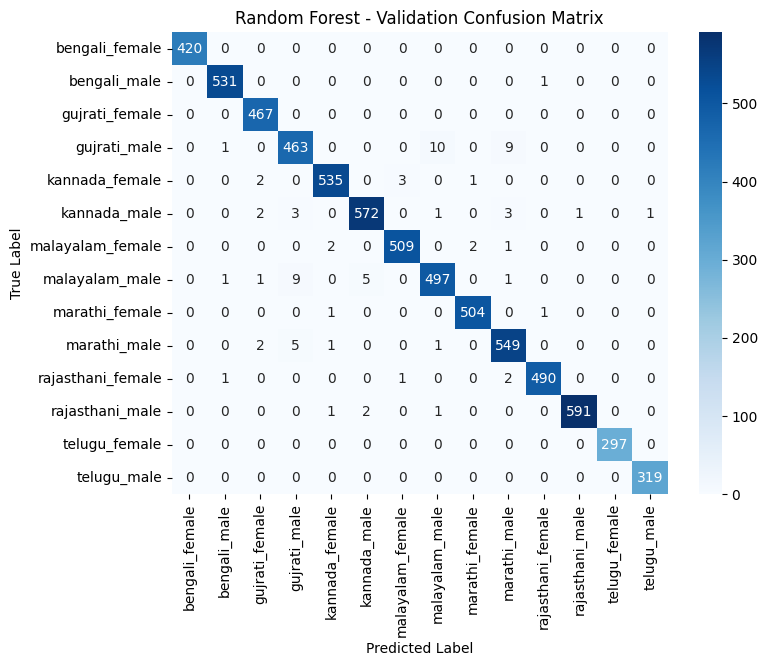

Random Forest Validation Accuracy: 98.84%

Test Set Results:


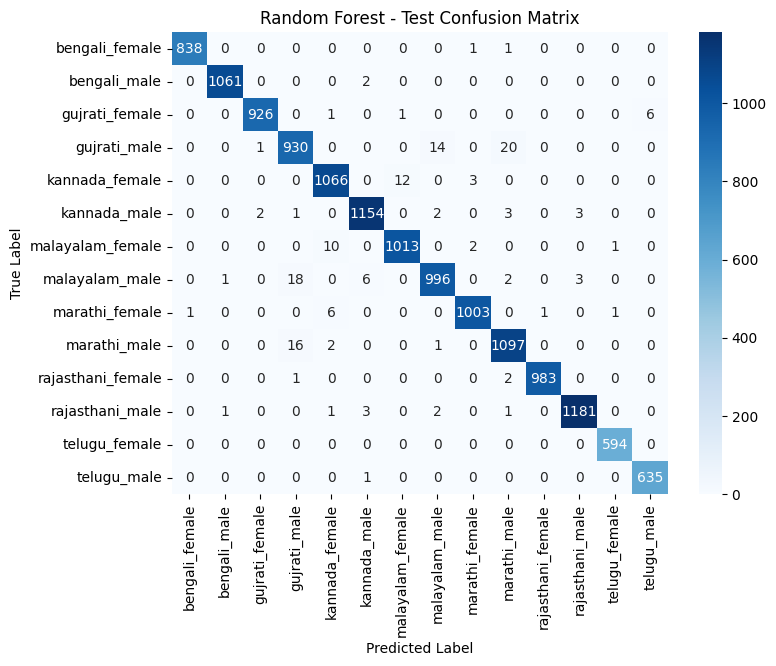

Evaluating Models:  50%|████████████████████████████████                                | 3/6 [08:34<06:28, 129.56s/it]

Random Forest Test Accuracy: 98.86%

Evaluating XGBoost:

Training Set Results:


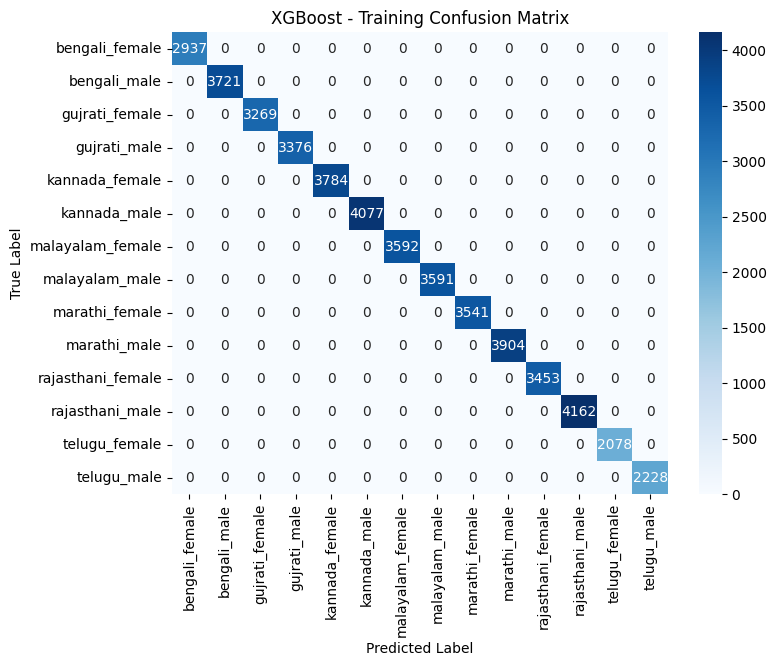

XGBoost Training Accuracy: 100.00%

Validation Set Results:


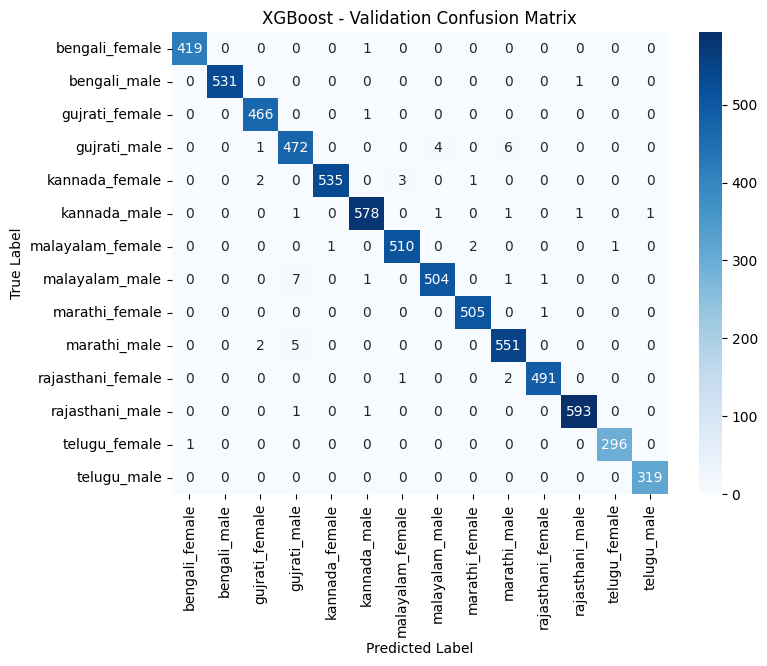

XGBoost Validation Accuracy: 99.22%

Test Set Results:


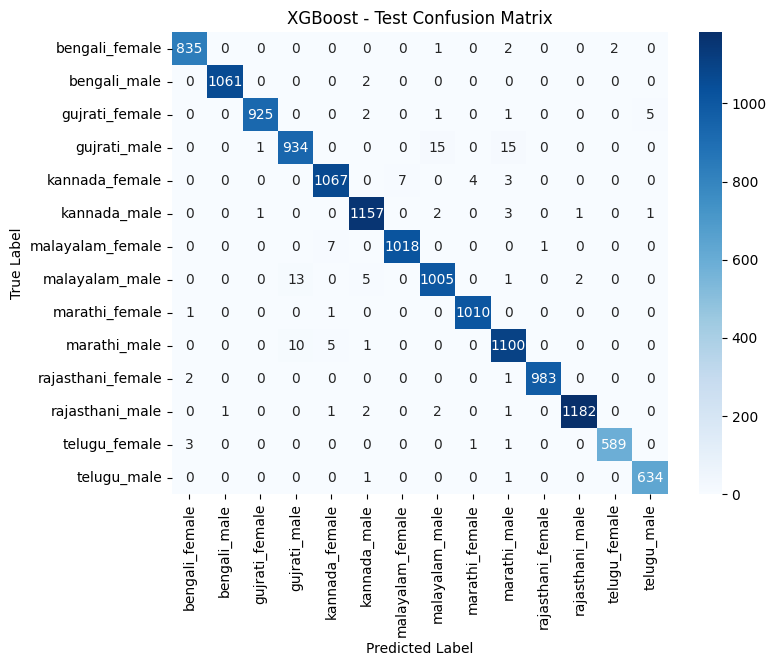

Evaluating Models:  67%|███████████████████████████████████████████▎                     | 4/6 [08:46<02:46, 83.19s/it]

XGBoost Test Accuracy: 99.02%

Evaluating Decision Tree:

Training Set Results:


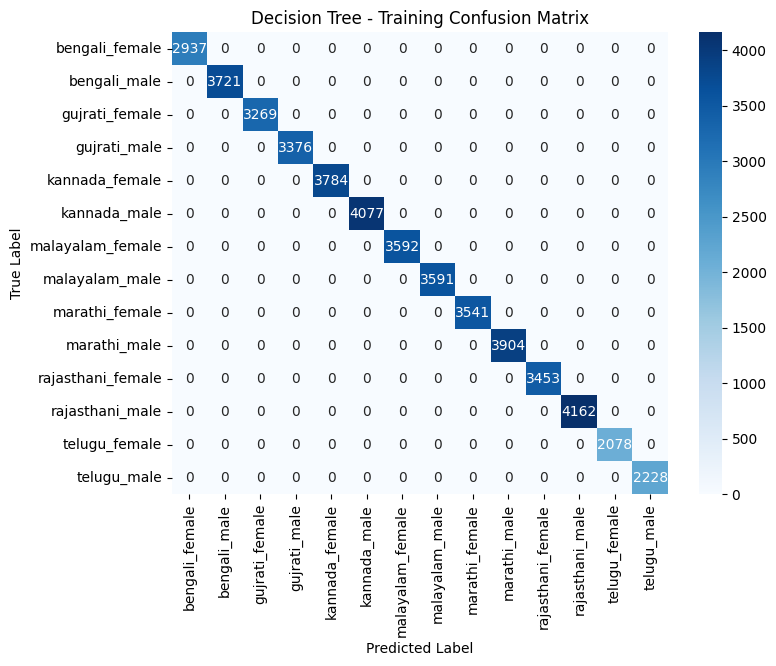

Decision Tree Training Accuracy: 100.00%

Validation Set Results:


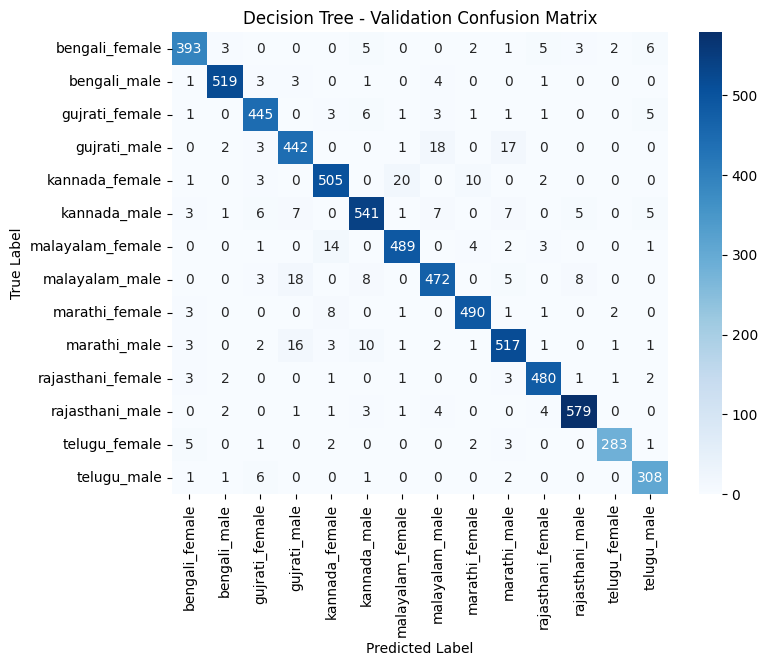

Decision Tree Validation Accuracy: 94.72%

Test Set Results:


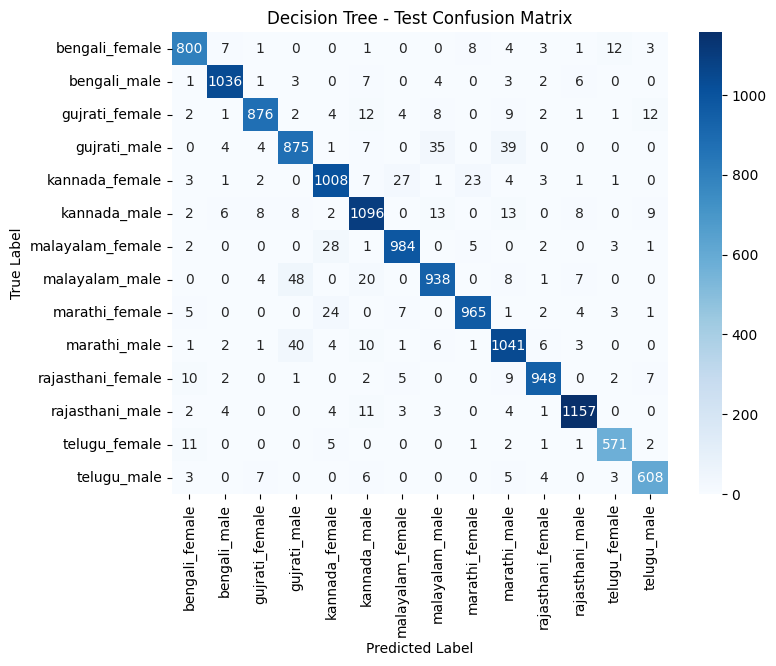

Evaluating Models:  83%|██████████████████████████████████████████████████████▏          | 5/6 [08:50<00:54, 54.64s/it]

Decision Tree Test Accuracy: 94.65%

Evaluating CNN-LSTM:

Training Set Results:
1492/1492 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step


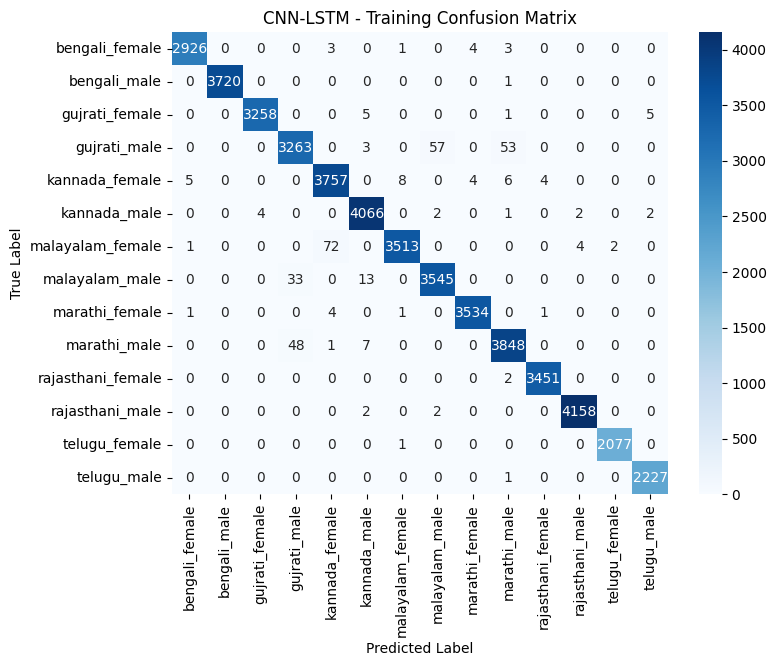

CNN-LSTM Training Accuracy: 99.22%

Validation Set Results:
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


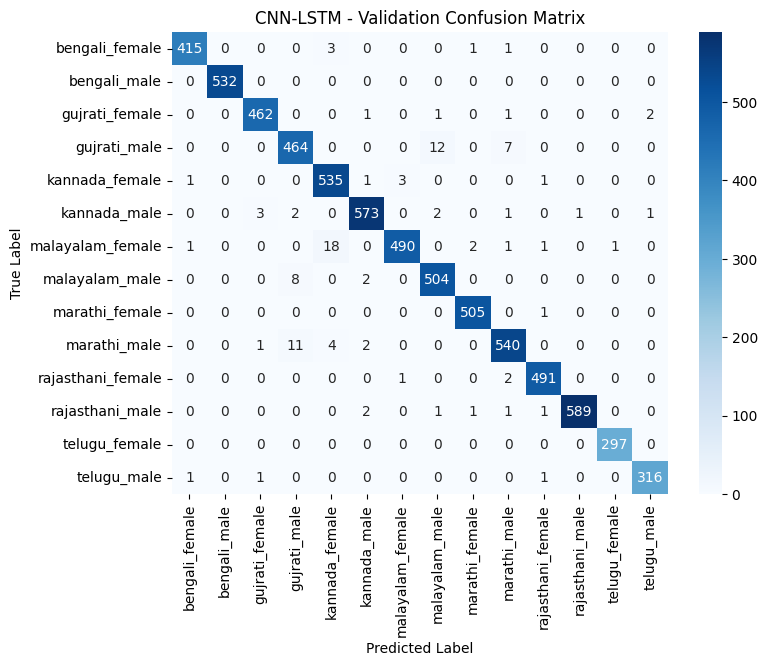

CNN-LSTM Validation Accuracy: 98.39%

Test Set Results:
427/427 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step


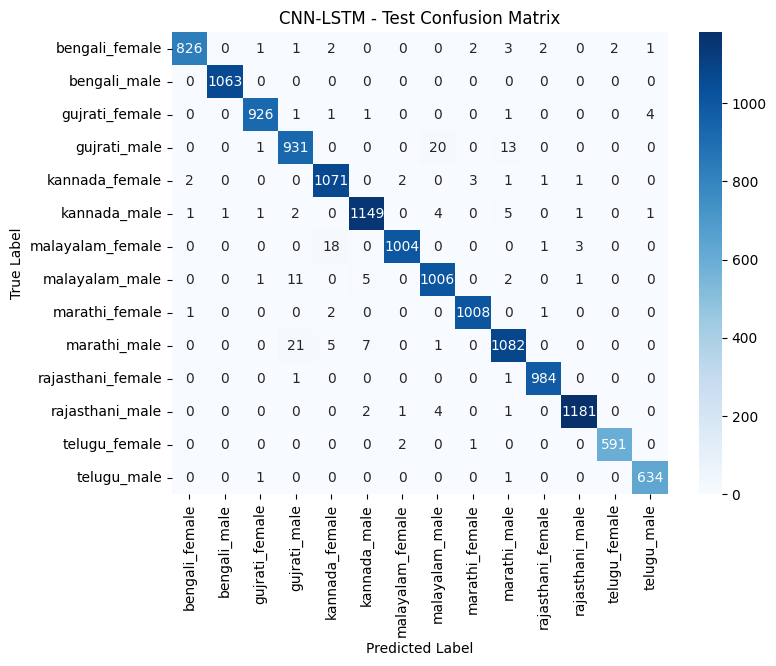

Evaluating Models: 100%|████████████████████████████████████████████████████████████████| 6/6 [11:30<00:00, 115.16s/it]

CNN-LSTM Test Accuracy: 98.70%

Best model saved at F:/ACCENT_SPEECH_RECOGNITION/models\best_accent_model.pkl


In [6]:
import os
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import tqdm

# Define output directory
output_dir = "F:/ACCENT_SPEECH_RECOGNITION/models"

# Load cross-validation results and datasets
results, _ = joblib.load(os.path.join(output_dir, "cv_results.pkl"))
X_train, y_train = joblib.load(os.path.join(output_dir, "train_data.pkl"))
X_test, y_test = joblib.load(os.path.join(output_dir, "test_data.pkl"))
X_val, y_val = joblib.load(os.path.join(output_dir, "validation_data.pkl"))
label_encoder = joblib.load(os.path.join(output_dir, "label_encoder.pkl"))
y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_val_encoded = label_encoder.transform(y_val)

# Reshape data for CNN-LSTM
X_train_cnn_lstm = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn_lstm = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_val_cnn_lstm = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

# Load the CNN-LSTM model from saved file
cnn_lstm_model = load_model(os.path.join(output_dir, "cnn_lstm_accent_model.h5"))

# Compile the model with a new optimizer
cnn_lstm_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model dictionary including the CNN-LSTM model
model_mapping = {
    "SVM": SVC(),
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "CNN-LSTM": cnn_lstm_model  # Loaded pre-built model
}

# Function for evaluation and plotting
def evaluate_and_plot(model, X, y_true, title, is_cnn_lstm=False):
    if is_cnn_lstm:
        y_pred = model.predict(X).argmax(axis=-1)
    else:
        y_pred = model.predict(X)
    accuracy = accuracy_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt='g', 
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f"{title} Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    
    return accuracy

# Evaluate each model and plot results
for model_name, model in tqdm(model_mapping.items(), desc="Evaluating Models"):
    print(f"\nEvaluating {model_name}:")

    # Reshape data for CNN-LSTM
    is_cnn_lstm = model_name == "CNN-LSTM"
    X_train_eval = X_train_cnn_lstm if is_cnn_lstm else X_train
    X_val_eval = X_val_cnn_lstm if is_cnn_lstm else X_val
    X_test_eval = X_test_cnn_lstm if is_cnn_lstm else X_test

    # Train model and evaluate accuracy
    if is_cnn_lstm:
        model.fit(X_train_eval, y_train_encoded, epochs=10, batch_size=32, verbose=0)
    else:
        model.fit(X_train_eval, y_train_encoded)

    # Training results
    print("\nTraining Set Results:")
    train_accuracy = evaluate_and_plot(model, X_train_eval, y_train_encoded, f"{model_name} - Training", is_cnn_lstm)
    print(f"{model_name} Training Accuracy: {train_accuracy * 100:.2f}%")

    # Validation results
    print("\nValidation Set Results:")
    val_accuracy = evaluate_and_plot(model, X_val_eval, y_val_encoded, f"{model_name} - Validation", is_cnn_lstm)
    print(f"{model_name} Validation Accuracy: {val_accuracy * 100:.2f}%")

    # Test results
    print("\nTest Set Results:")
    test_accuracy = evaluate_and_plot(model, X_test_eval, y_test_encoded, f"{model_name} - Test", is_cnn_lstm)
    print(f"{model_name} Test Accuracy: {test_accuracy * 100:.2f}%")

# Save best model
best_model_name = max(results, key=results.get)
best_model = model_mapping[best_model_name]
joblib.dump(best_model, os.path.join(output_dir, "best_accent_model.pkl"))
print("\nBest model saved at", os.path.join(output_dir, "best_accent_model.pkl"))


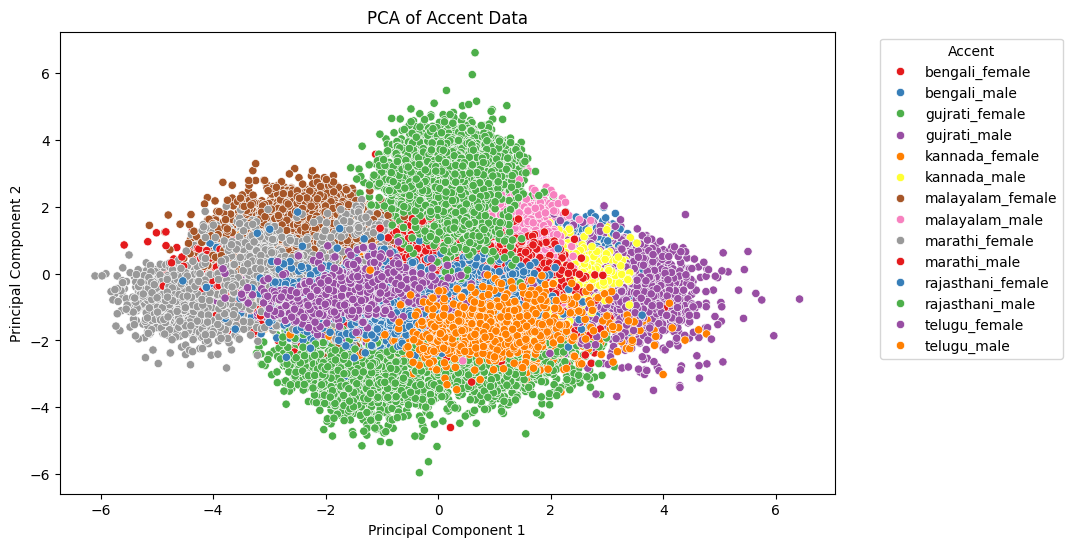

C:\Users\abhis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


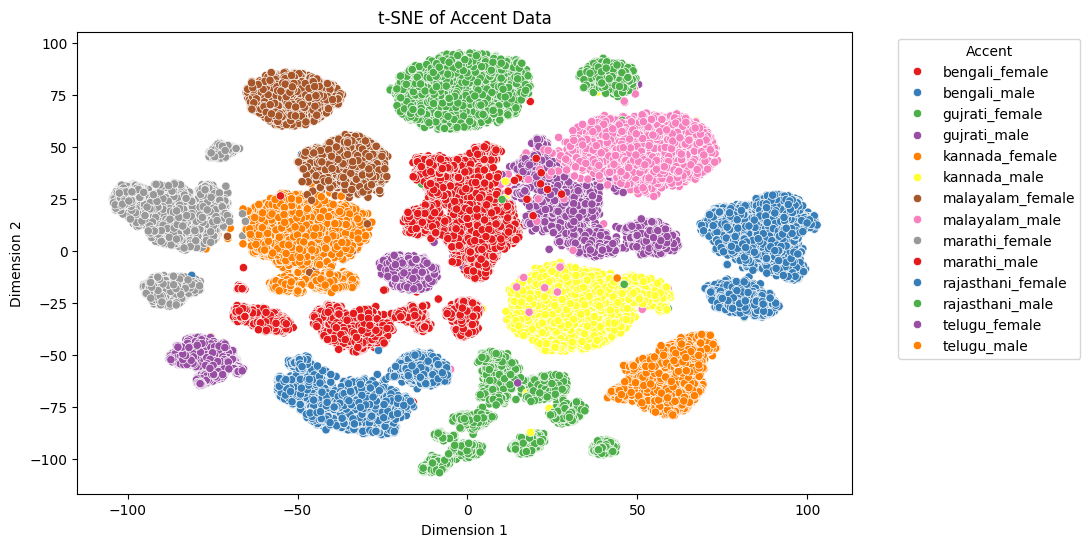

In [1]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# Load data for visualization (adjust the path to your output directory)
output_dir = "F:/ACCENT_SPEECH_RECOGNITION/models"
X_train, y_train = joblib.load(os.path.join(output_dir, "train_data.pkl"))
X_test, y_test = joblib.load(os.path.join(output_dir, "test_data.pkl"))
label_encoder = joblib.load(os.path.join(output_dir, "label_encoder.pkl"))

# Combine train and test data for visualization
X = np.vstack([X_train, X_test])
y = np.concatenate([y_train, y_test])
y_encoded = label_encoder.transform(y)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA for dimensionality reduction
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

# Create a DataFrame for the PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_df['label'] = label_encoder.inverse_transform(y_encoded)

# Plotting the PCA results
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='label', data=pca_df, palette='Set1')
plt.title('PCA of Accent Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Accent', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
tsne_result = tsne.fit_transform(X_scaled)

# Create a DataFrame for the t-SNE results
tsne_df = pd.DataFrame(data=tsne_result, columns=['Dim1', 'Dim2'])
tsne_df['label'] = label_encoder.inverse_transform(y_encoded)

# Plotting the t-SNE results
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Dim1', y='Dim2', hue='label', data=tsne_df, palette='Set1')
plt.title('t-SNE of Accent Data')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(title='Accent', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [2]:
import os

# Base path of your dataset
base_path = "F:/ACCENT_SPEECH_RECOGNITION/DataBase/Split_Data"

# Initialize counters
total_train = 0
total_test = 0
total_val = 0
accent_counts = {}

# Define subsets and count total files for each subset
for subset in ['train', 'test', 'validation']:
    subset_path = os.path.join(base_path, subset)
    for accent_gender in os.listdir(subset_path):
        accent_path = os.path.join(subset_path, accent_gender)
        if os.path.isdir(accent_path):
            files = [f for f in os.listdir(accent_path) if f.endswith('.wav')]
            count = len(files)
            
            # Add count to respective subset
            if subset == 'train':
                total_train += count
            elif subset == 'test':
                total_test += count
            elif subset == 'validation':
                total_val += count
            
            # Count files for each accent and gender
            accent_gender_key = accent_gender
            if accent_gender_key not in accent_counts:
                accent_counts[accent_gender_key] = 0
            accent_counts[accent_gender_key] += count

# Print dataset summary
print("Dataset Summary:")
print(f"Total audios in Train set: {total_train}")
print(f"Total audios in Test set: {total_test}")
print(f"Total audios in Validation set: {total_val}")

# Sample rate and other specific parameters
video_length = 10  # assuming each audio is around 10 seconds
sample_rate = 22050  # assuming a standard sample rate for audio files

print("\nAudio Dataset Attributes:")
print(f"Audio Length (per file): {video_length} secs")
print(f"Sample Rate: {sample_rate} Hz")

# Print total number of audios for each accent (male and female separately)
print("\nTotal number of audios for each accent (male and female):")
for accent_gender, count in accent_counts.items():
    print(f"{accent_gender}: {count}")


Dataset Summary:
Total audios in Train set: 47713
Total audios in Test set: 13633
Total audios in Validation set: 6823

Audio Dataset Attributes:
Audio Length (per file): 10 secs
Sample Rate: 22050 Hz

Total number of audios for each accent (male and female):
bengali_female: 4197
bengali_male: 5316
gujrati_female: 4670
gujrati_male: 4824
kannada_female: 5406
kannada_male: 5825
malayalam_female: 5132
malayalam_male: 5131
marathi_female: 5059
marathi_male: 5578
rajasthani_female: 4933
rajasthani_male: 5946
telugu_female: 2969
telugu_male: 3183


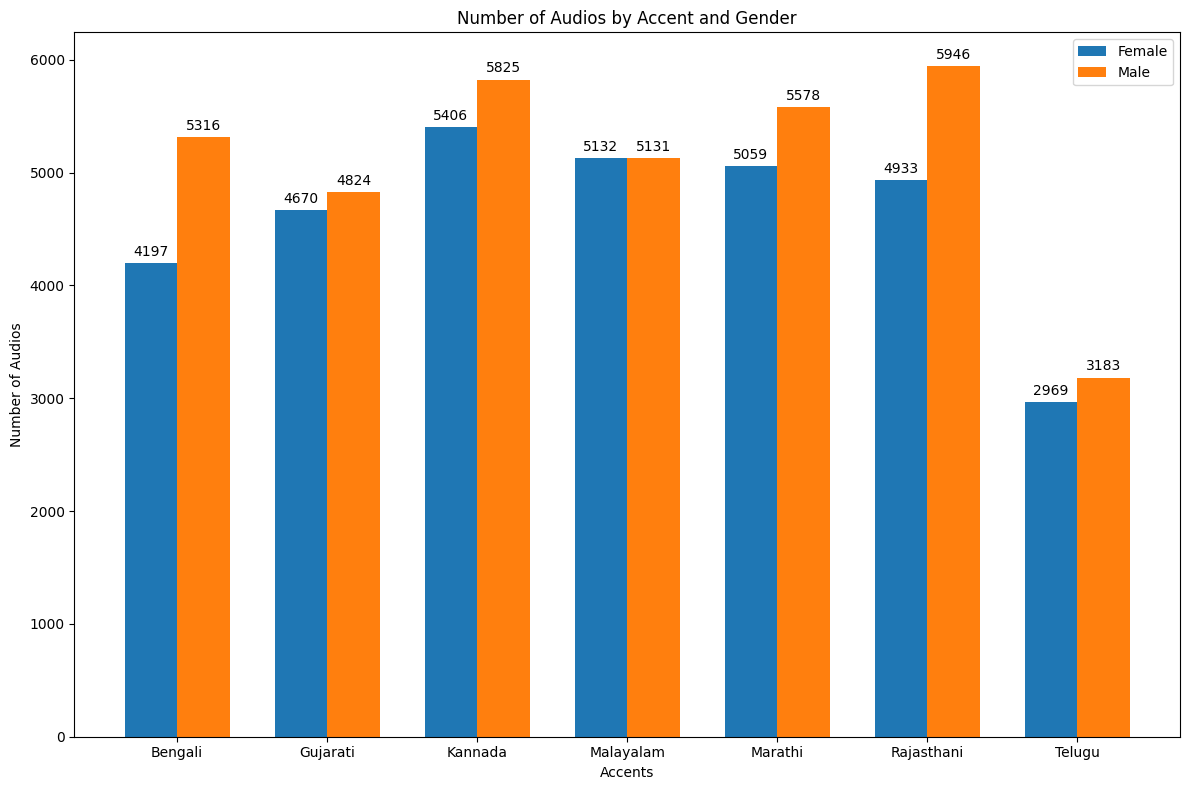

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Accent data
accents = ['Bengali', 'Gujarati', 'Kannada', 'Malayalam', 'Marathi', 'Rajasthani', 'Telugu']
female_counts = [4197, 4670, 5406, 5132, 5059, 4933, 2969]
male_counts = [5316, 4824, 5825, 5131, 5578, 5946, 3183]

x = np.arange(len(accents))  # the label locations
width = 0.35  # the width of the bars

# Increase the figure size
fig, ax = plt.subplots(figsize=(12, 8))  # Width, Height in inches
rects1 = ax.bar(x - width/2, female_counts, width, label='Female')
rects2 = ax.bar(x + width/2, male_counts, width, label='Male')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Accents')
ax.set_ylabel('Number of Audios')
ax.set_title('Number of Audios by Accent and Gender')
ax.set_xticks(x)
ax.set_xticklabels(accents)
ax.legend()

# Function to attach a label above each bar in rects, displaying its height.
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()
